In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
infos = pd.read_csv('../../data/infos.csv', sep = '|')

In [3]:
items = pd.read_csv('../../data/items.csv', sep = '|')

In [4]:
orders = pd.read_csv('../../data/orders.csv', sep = '|', parse_dates=['time'])

## - Creating the structure

In [5]:
df = orders.copy()

In [6]:
# We want the 14 dats between June 16 and June 29 to be the week pair -1
print((pd.Series(['2018-06-30 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-29 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-16 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-15 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

0    0
dtype: int64
0   -1
dtype: int64
0   -1
dtype: int64
0   -2
dtype: int64


In [7]:
df['weekpair'] = (df.time.dt.dayofyear + 1) // 14 - 13

In [8]:
df.weekpair.max(), df.weekpair.min()

(-1, -13)

In [9]:
npairs = df.weekpair.nunique()

In [10]:
n_items = items['itemID'].nunique()
print('total number of items:', n_items)
print('expected number of instances:', n_items * npairs)

total number of items: 10463
expected number of instances: 136019


In [11]:
mi = pd.MultiIndex.from_product([range(-npairs, 0), items['itemID']], names=['weekpair', 'itemID'])
data = pd.DataFrame(index = mi)

In [12]:
data = data.join(df.groupby(['weekpair', 'itemID'])[['order']].sum(), how = 'left')

In [13]:
data.fillna(0, inplace = True)

In [14]:
data.groupby('itemID').count().min()

order    13
dtype: int64

In [15]:
data

order
weekpair itemID       
-13      1         0.0
         2         0.0
         3         1.0
         4         0.0
         5         2.0
...                ...
-1       10459     0.0
         10460     0.0
         10461     0.0
         10462     0.0
         10463     0.0

[136019 rows x 1 columns]

## - Creating features

In [16]:
data.reset_index(inplace = True)

In [17]:
data = pd.merge(data, items[['itemID', 'manufacturer', 'category1', 'category2', 'category3']], on = 'itemID')

In [18]:
data.sort_values('weekpair', inplace = True)

In [19]:
data

,weekpair,itemID,order,manufacturer,category1,category2,category3
0,-13,1,0.0,1,1,1,1
83304,-13,6409,0.0,159,5,32,4
118534,-13,9119,0.0,242,8,44,8
17485,-13,1346,0.0,35,1,5,1
52702,-13,4055,0.0,86,2,8,2
...,...,...,...,...,...,...,...
59565,-1,4582,0.0,127,6,19,3
76452,-1,5881,0.0,159,5,32,4
46682,-1,3591,4.0,86,2,8,2
126372,-1,9721,0.0,240,8,43,8


In [20]:
# features = [
#     ('itemID', 'item'),
#     ('manufacturer', 'manuf'),
#     ('category1', 'cat1'),
#     ('category2', 'cat2'),
#     ('category3', 'cat3')
# ]
# for f, n in features:
#     if f not in data.columns:
#         print('ops', f)

In [21]:
features = [('itemID', 'item')]

In [22]:
# f, name = ('manufacturer', 'manuf')
for f, name in features:
    print(f)
    temp = data.groupby([f, 'weekpair'])[['order']].sum()
    shifted = temp.groupby(f)[['order']].shift(1)
    new_feature_block = pd.DataFrame()
    for n in range(3):
        rolled = shifted.groupby(f, as_index = False)['order'].rolling(2 ** n).mean()
        new_feature_block['%s_%d' % (name, 2 ** n)] = rolled.reset_index(0, drop = True) # rolling has a weird index behavior...
    data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])

itemID


In [23]:
data.count() # the larger the window, more NaN are expected

weekpair        136019
itemID          136019
order           136019
manufacturer    136019
category1       136019
category2       136019
category3       136019
item_1          125556
item_2          115093
item_4           94167
dtype: int64

In [24]:
data.fillna(-1, inplace=True)

In [25]:
# checking if we got what we wanted
data.query('itemID == 1')

,weekpair,itemID,order,manufacturer,category1,category2,category3,item_1,item_2,item_4
0,-13,1,0.0,1,1,1,1,-1.0,-1.0,-1.00
18147,-12,1,2.0,1,1,1,1,0.0,-1.0,-1.00
22186,-11,1,313.0,1,1,1,1,2.0,1.0,-1.00
40563,-10,1,35.0,1,1,1,1,313.0,157.5,-1.00
45531,-9,1,3.0,1,1,1,1,35.0,174.0,87.50
53034,-8,1,1.0,1,1,1,1,3.0,19.0,88.25
73176,-7,1,1.0,1,1,1,1,1.0,2.0,88.00
83408,-6,1,2.0,1,1,1,1,1.0,1.0,10.00
84819,-5,1,299.0,1,1,1,1,2.0,1.5,1.75
96577,-4,1,3.0,1,1,1,1,299.0,150.5,75.75


In [26]:
# data['feature'] = data.groupby('itemID')['order'].apply(lambda x : (x > 0).cumsum()) / (data['weekpair'] + 1)

In [27]:
counts = data.groupby('itemID')['order'].apply(lambda x : (x > 0).sum())

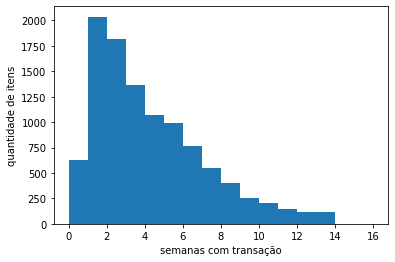

In [30]:
plt.hist(counts, bins = range(17))
plt.ylabel('quantidade de itens')
plt.xlabel('semanas com transação')
plt.show()

In [31]:
# f = 'itemID'
# temp = data.groupby([f, 'week'])[['order']].sum()
# shifted = temp.groupby(f)[['order']].shift(1)
# data['feature'] = (shifted.fillna(0) > 0).groupby(f)[['order']].cumsum().values

In [32]:
data.head()

,weekpair,itemID,order,manufacturer,category1,category2,category3,item_1,item_2,item_4
0,-13,1,0.0,1,1,1,1,-1.0,-1.0,-1.0
1,-13,6409,0.0,159,5,32,4,-1.0,-1.0,-1.0
2,-13,9119,0.0,242,8,44,8,-1.0,-1.0,-1.0
3,-13,1346,0.0,35,1,5,1,-1.0,-1.0,-1.0
4,-13,4055,0.0,86,2,8,2,-1.0,-1.0,-1.0


##  - Split Data

In [33]:
filtered_data = data

In [34]:
sub_week = -1
train = filtered_data.query('-13 <= weekpair <= (@sub_week - 2)').reset_index()
test = filtered_data.query('weekpair == (@sub_week - 1)').reset_index()
sub = filtered_data.query('weekpair == (@sub_week)').reset_index()

In [35]:
filtered_data.query('weekpair == @sub_week').query('itemID == 4')

,weekpair,itemID,order,manufacturer,category1,category2,category3,item_1,item_2,item_4
126215,-1,4,145.0,2,1,2,1,0.0,2.5,12.25


In [36]:
len(train), len(test), len(sub)

(115093, 10463, 10463)

In [37]:
weights = infos.set_index('itemID')['simulationPrice'].to_dict()

In [38]:
y_train = train.pop('order').values
y_test = test.pop('order').values
y_sub = sub.pop('order').values

X_train = train.values
X_test = test.values
X_sub = sub.values

w_train = train['itemID'].map(weights)
w_test = test['itemID'].map(weights)
w_sub = sub['itemID'].map(weights)

<hr>

## - Min Expected Error

In [39]:
# max expected rmse
from sklearn.metrics import mean_squared_error as mse
# pred = data.loc[1:12].groupby('itemID')['order'].mean().sort_index()
# target_week = data.loc[13:, 'order'].reset_index(level = 0, drop = True).sort_index()
# mse(target_week, pred) ** .5

<hr>

## - XGBoost

In [40]:
import xgboost as xgb

In [54]:
# custom objective

def gradient(predt, dtrain):
    y = dtrain.get_label()
#     predt.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    return -2 * (predt - np.maximum(predt - y, 0) * 1.6) * (1 - (predt > y) * 1.6)

def hessian(predt, dtrain):
    y = dtrain.get_label()
#     predt.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    return -2 * (1 - (predt > y) * 1.6) ** 2

def objective(predt, dtrain):
    w = dtrain.get_weight()
    grad = gradient(predt, dtrain) * w
    hess = hessian(predt, dtrain) * w
    return grad, hess

In [55]:
# custom feval

def feval(predt: np.ndarray, dtrain: xgb.DMatrix):
    predt = predt.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', -np.sum((predt - np.maximum(predt - target, 0) * 1.6)  * simulationPrice)

In [72]:
dtrain = xgb.DMatrix(X_train, y_train, w_train, missing = -1)
dtest = xgb.DMatrix(X_test, y_test, w_test, missing = -1)
dsub = xgb.DMatrix(X_sub, y_sub, w_sub, missing = -1)
# specify parameters via map
param = {
    'max_depth':6,
    'eta':0.005,
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1
}
num_round = 100
bst = xgb.train(param, dtrain,
                num_round, early_stopping_rounds = 5,
#                 obj = objective,
                feval = feval,
                evals = [(dtrain, 'train'), (dsub, 'dsub'), (dtest, 'test')])

[0]	train-feval:-15609.78800	dsub-feval:-2632.38000	test-feval:-2129.74001
Multiple eval metrics have been passed: 'test-feval' will be used for early stopping.

Will train until test-feval hasn't improved in 5 rounds.
[1]	train-feval:-79534.35006	dsub-feval:-11171.31402	test-feval:-8699.33201
[2]	train-feval:-106385.95608	dsub-feval:-16125.86401	test-feval:-12984.25201
[3]	train-feval:-124896.48412	dsub-feval:-17052.15602	test-feval:-13241.16601
[4]	train-feval:-75863.78836	dsub-feval:-24565.84013	test-feval:-21663.01607
[5]	train-feval:-105806.32442	dsub-feval:-29180.37617	test-feval:-22631.70208
[6]	train-feval:-145508.91665	dsub-feval:-48209.68417	test-feval:-39671.35801
[7]	train-feval:-159379.72059	dsub-feval:-49149.14218	test-feval:-39965.15600
[8]	train-feval:-171982.72259	dsub-feval:-50628.81616	test-feval:-41056.66398
[9]	train-feval:-186034.18864	dsub-feval:-54379.47418	test-feval:-40779.67597
[10]	train-feval:-197938.10266	dsub-feval:-55419.67217	test-feval:-40647.18795
[11

In [65]:
prediction = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
simulationPrice = w_sub
target = y_sub
-np.sum((prediction - np.maximum(prediction - target, 0) * 1.6) * simulationPrice)

-54478.10199999999

In [62]:
submission = items[['itemID']].copy()
submission['demandPrediction'] = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
submission.to_csv('../../submissions/sub_inclass_03.csv', sep = '|', index=False)
# submission.head()

<hr>

## - LGB

<hr>

## - CatBoost

<hr>

## - Linear Regression

In [401]:
def evaluate(prediction, target, simulatedPrice):
    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulatedPrice)

In [398]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import 

In [399]:
lr = LinearRegression()

In [408]:
lr.fit(X_train, y_train, w_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [409]:
print('train', evaluate(lr.predict(X_train), y_train, w_train))
print('test', evaluate(lr.predict(X_test), y_test, w_test))
print('sub', evaluate(lr.predict(X_sub), y_sub, w_sub))

train -21616860.89586201
test -2597637.322313344
sub -7671684.811105296


<hr>

In [ ]:
# fazer feature que pega o percentil de quando o item deu de dinheiro dentro de uma categoria
# fazer features que pega dist de atual até o pico mais alto
# dist do maior pico pro segundo
# min(dist(terceiro, primeiro), dist(terceiro, segundo))